In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

1. # **Importing the data from kaggle repository**

In [3]:
dir='/kaggle/input/brain-mri-images-for-brain-tumor-detection'
import tensorflow as tf
import h5py
import numpy as np
import os
import cv2
from sklearn.metrics import precision_score,recall_score,f1_score,roc_auc_score
from imblearn.metrics import sensitivity_specificity_support
from sklearn.preprocessing import StandardScaler
%config Completer.use_jedi = False

In [4]:
x_dataset=[]
y_dataset=[]
src=os.listdir('/kaggle/input/brain-mri-images-for-brain-tumor-detection/no')
i=0
for filename in src:
    full_file_name='/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/'+filename
    x=cv2.imread(full_file_name)
    x=np.array(x,dtype='float32')
    y=0
    y=np.array(y,dtype='float32')
    x=x/255.0
    x=cv2.resize(x,(224,224))
    x_dataset.append(x)
    y_dataset.append(y)
    i=i+1
    print(i)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98


In [5]:

src=os.listdir('/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes')
for filename in src:
    full_file_name='/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes/'+filename
    x=cv2.imread(full_file_name)
    x=np.array(x,dtype='float32')
    y=1
    y=np.array(y,dtype='float32')
    x=x/255.0
    x=cv2.resize(x,(224,224))
    x_dataset.append(x)
    y_dataset.append(y)
    i=i+1
    print(i)

99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253


In [6]:
X_dataset=np.array(x_dataset)
Y_dataset=np.array(y_dataset)
Y_dataset=Y_dataset.reshape((253,1))

# Now shuffling the whole dataset such that samples get mixed 

In [7]:
from sklearn.utils import shuffle
X_dataset,Y_dataset=shuffle(X_dataset,Y_dataset,random_state=0)

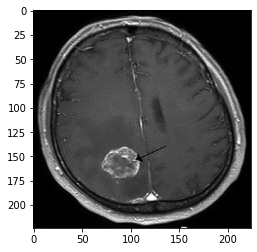

In [8]:
import matplotlib.pyplot as plt
plt.imshow(X_dataset[2])
plt.show()

In [9]:
yes_len=0
no_len=0
for i in range(253):
    if Y_dataset[i]==0:
        no_len+=1
    else:
        yes_len+=1
print(yes_len)
print(no_len)

155
98


<AxesSubplot:>

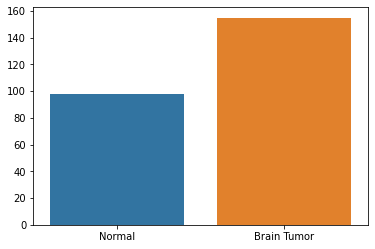

In [10]:
import seaborn as sns
sns.barplot(x=['Normal','Brain Tumor'],y=[no_len,yes_len])

Breakdown in Train and Test set

In [11]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X_dataset,Y_dataset,test_size=0.20)

In [12]:
from sklearn.model_selection import StratifiedShuffleSplit
folds=list(StratifiedShuffleSplit(n_splits=5,random_state=1).split(x_train,y_train))

In [24]:
nasnet=tf.keras.applications.inception_v3.InceptionV3(include_top=False,input_shape=(224,224,3))
x=tf.keras.layers.Flatten()(nasnet.output)
x=tf.keras.layers.Dense(1)(x)
out=tf.keras.layers.Activation(activation='sigmoid')(x)

model=tf.keras.Model(inputs=nasnet.input,outputs=out)

model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001),loss='binary_crossentropy',metrics=['accuracy'])

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 111, 111, 32) 128         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           stem_bn1[0][0]                   
______________________________________________________________________________________________

In [21]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import auc,roc_curve
from matplotlib import pyplot as plt

In [22]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(  rotation_range=8,
                                     width_shift_range=0.03,
                                     height_shift_range=0.03,
                                     shear_range=0.25,
                                     zoom_range=0.45,
                                     horizontal_flip=True)
val_datagen = ImageDataGenerator(zoom_range=0.45)

Fold 1
Epoch 1/20
6/6 [==============================] - 14s 789ms/step - loss: 0.7444 - accuracy: 0.6513 - val_loss: 0.6870 - val_accuracy: 0.6667
Epoch 2/20
6/6 [==============================] - 2s 350ms/step - loss: 0.3386 - accuracy: 0.8559 - val_loss: 0.4083 - val_accuracy: 0.8095
Epoch 3/20
6/6 [==============================] - 2s 344ms/step - loss: 0.2794 - accuracy: 0.8921 - val_loss: 0.6440 - val_accuracy: 0.6667
Epoch 4/20
6/6 [==============================] - 2s 348ms/step - loss: 0.1947 - accuracy: 0.9292 - val_loss: 1.0058 - val_accuracy: 0.6190
Epoch 5/20
6/6 [==============================] - 2s 346ms/step - loss: 0.0735 - accuracy: 0.9804 - val_loss: 1.3850 - val_accuracy: 0.5714
Epoch 6/20
6/6 [==============================] - 2s 376ms/step - loss: 0.1231 - accuracy: 0.9274 - val_loss: 0.4956 - val_accuracy: 0.8095
Epoch 7/20
6/6 [==============================] - 2s 358ms/step - loss: 0.0801 - accuracy: 0.9697 - val_loss: 0.2972 - val_accuracy: 0.8095
Epoch 8/20
6

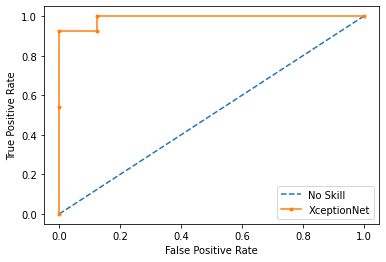

Fold 2
Epoch 1/20
6/6 [==============================] - 2s 363ms/step - loss: 0.0623 - accuracy: 0.9890 - val_loss: 0.0185 - val_accuracy: 1.0000
Epoch 2/20
6/6 [==============================] - 2s 372ms/step - loss: 0.0390 - accuracy: 0.9890 - val_loss: 0.0031 - val_accuracy: 1.0000
Epoch 3/20
6/6 [==============================] - 2s 398ms/step - loss: 0.0415 - accuracy: 0.9834 - val_loss: 0.0601 - val_accuracy: 0.9524
Epoch 4/20
6/6 [==============================] - 2s 348ms/step - loss: 0.0577 - accuracy: 0.9890 - val_loss: 0.0035 - val_accuracy: 1.0000
Epoch 5/20
6/6 [==============================] - 2s 355ms/step - loss: 0.0282 - accuracy: 0.9890 - val_loss: 0.0596 - val_accuracy: 0.9524
Epoch 6/20
6/6 [==============================] - 2s 356ms/step - loss: 0.0276 - accuracy: 0.9890 - val_loss: 3.2206e-04 - val_accuracy: 1.0000
Epoch 7/20
6/6 [==============================] - 3s 437ms/step - loss: 0.0714 - accuracy: 0.9834 - val_loss: 0.1105 - val_accuracy: 0.9524
Epoch 8/2

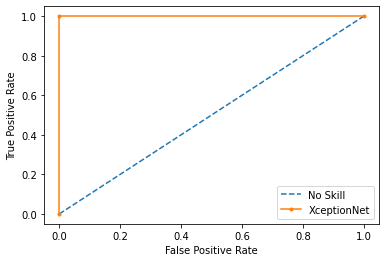

Fold 3
Epoch 1/20
6/6 [==============================] - 3s 452ms/step - loss: 0.0193 - accuracy: 0.9945 - val_loss: 0.4911 - val_accuracy: 0.9048
Epoch 2/20
6/6 [==============================] - 2s 395ms/step - loss: 0.0184 - accuracy: 0.9945 - val_loss: 0.1685 - val_accuracy: 0.9048
Epoch 3/20
6/6 [==============================] - 2s 346ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0714 - val_accuracy: 0.9524
Epoch 4/20
6/6 [==============================] - 2s 347ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0137 - val_accuracy: 1.0000
Epoch 5/20
6/6 [==============================] - 2s 344ms/step - loss: 0.0785 - accuracy: 0.9779 - val_loss: 0.0038 - val_accuracy: 1.0000
Epoch 6/20
6/6 [==============================] - 2s 345ms/step - loss: 0.0152 - accuracy: 0.9890 - val_loss: 0.0017 - val_accuracy: 1.0000
Epoch 7/20
6/6 [==============================] - 2s 425ms/step - loss: 0.0081 - accuracy: 1.0000 - val_loss: 0.0118 - val_accuracy: 1.0000
Epoch 8/20
6/

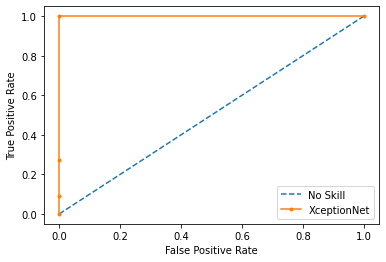

Fold 4
Epoch 1/20
6/6 [==============================] - 3s 420ms/step - loss: 0.0065 - accuracy: 0.9945 - val_loss: 0.0083 - val_accuracy: 1.0000
Epoch 2/20
6/6 [==============================] - 2s 347ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 5.9550e-04 - val_accuracy: 1.0000
Epoch 3/20
6/6 [==============================] - 2s 347ms/step - loss: 0.0941 - accuracy: 0.9834 - val_loss: 8.9771e-05 - val_accuracy: 1.0000
Epoch 4/20
6/6 [==============================] - 2s 345ms/step - loss: 0.0103 - accuracy: 0.9945 - val_loss: 4.4974e-06 - val_accuracy: 1.0000
Epoch 5/20
6/6 [==============================] - 2s 351ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 5.3915e-06 - val_accuracy: 1.0000
Epoch 6/20
6/6 [==============================] - 2s 370ms/step - loss: 3.6321e-04 - accuracy: 1.0000 - val_loss: 5.4088e-06 - val_accuracy: 1.0000
Epoch 7/20
6/6 [==============================] - 2s 345ms/step - loss: 3.3937e-04 - accuracy: 1.0000 - val_loss: 2.0671e-06 - va

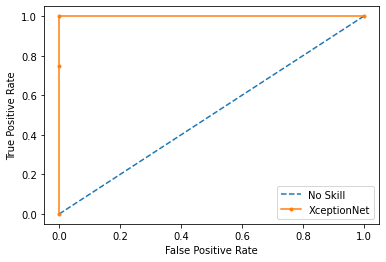

Fold 5
Epoch 1/20
6/6 [==============================] - 2s 380ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 2.1669e-04 - val_accuracy: 1.0000
Epoch 2/20
6/6 [==============================] - 2s 375ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.0010 - val_accuracy: 1.0000
Epoch 3/20
6/6 [==============================] - 2s 392ms/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 2.1537e-04 - val_accuracy: 1.0000
Epoch 4/20
6/6 [==============================] - 2s 353ms/step - loss: 0.0174 - accuracy: 0.9945 - val_loss: 6.5165e-04 - val_accuracy: 1.0000
Epoch 5/20
6/6 [==============================] - 2s 352ms/step - loss: 0.0173 - accuracy: 0.9945 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 6/20
6/6 [==============================] - 2s 356ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 7/20
6/6 [==============================] - 2s 349ms/step - loss: 8.8711e-05 - accuracy: 1.0000 - val_loss: 0.0014 - val_accuracy: 1.00

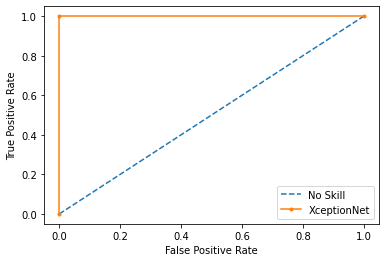

In [25]:
History=[]
Prescore=[]
Recall=[]
F1=[]
Sensspeci=[]
Roc_auc=[]
for j,(train_idx,val_idx) in enumerate(folds):
    print("Fold "+str(j+1))
    
    x_train=X_dataset[train_idx]
    y_train=Y_dataset[train_idx]
    x_val=X_dataset[val_idx]
    y_val=Y_dataset[val_idx]
    history=model.fit(train_datagen.flow(x_train,y_train),batch_size=8,epochs=20,validation_data=(x_val,y_val))
    y_predict=model.predict(x_val)
    Y_predict=np.float32(y_predict>0.50)
    l=len(y_val)
    Y_predict=np.reshape(Y_predict,(l,1))
    prescore=precision_score(y_val,Y_predict,average='binary')
    recaller=recall_score(y_val,Y_predict,average='binary')
    score=f1_score(y_val,Y_predict,average='binary')
    sensitivity=sensitivity_specificity_support(y_val,Y_predict,average='binary')
    print("Precision: ",prescore)
    print("Recall: ",recaller)
    print("F1-score ",score)
    print("Sensitivity ",sensitivity)
    History.append(history)
    Prescore.append(prescore)
    F1.append(score)
    Recall.append(recaller)
    Sensspeci.append(sensitivity)
    fpr, tpr, thresholds = roc_curve(y_val,y_predict)
    auc = roc_auc_score(y_val, y_predict)
    print("Precision: ",prescore)
    print("Recall: ",recaller)
    print("F1-score ",score)
    print("Sensitivity ",sensitivity)
    print("AUC: ",auc)
    plt.plot([0,1],[0,1], linestyle='--', label='No Skill')
    plt.plot(fpr,tpr, marker='.', label='XceptionNet')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

In [27]:
val_acc=History[0].history['val_accuracy']
val_acc1=History[1].history['val_accuracy']
val_acc2=History[2].history['val_accuracy']
val_acc3=History[3].history['val_accuracy']
val_acc4=History[4].history['val_accuracy']
Accuracvalid1=val_acc[19]
Accuracyvalid2=val_acc1[19]
Accuracyvalid3=val_acc2[19]
Accuracyvalid4=val_acc3[19]
Accuracyvalid5=val_acc4[19]
Mean_valid_Accuracy=(Accuracvalid1+Accuracyvalid2+Accuracyvalid3+Accuracyvalid4+Accuracyvalid5)/5.00
print("validation Accuracy for Fold-1 ",Accuracvalid1)
print("validation Accuracy for Fold-2",Accuracyvalid2)
print("Validation Accuracy for Fold-3 ",Accuracyvalid3)
print("Validation Accuracy for Fold-4  ",Accuracyvalid4)
print("Validation Accuracy for Fold-5  ",Accuracyvalid5)
print("Mean Validation Accuracy ",Mean_valid_Accuracy)

validation Accuracy for Fold-1  0.8571428656578064
validation Accuracy for Fold-2 0.9523809552192688
Validation Accuracy for Fold-3  0.9523809552192688
Validation Accuracy for Fold-4   1.0
Validation Accuracy for Fold-5   0.9523809552192688
Mean Validation Accuracy  0.9428571462631226


In [29]:
x_test.shape

(51, 224, 224, 3)

In [30]:
y_predict1=model.predict(x_test)
predict=np.float32(y_predict1>0.50)
predict=np.reshape(predict,(51,1))
print(predict)

[[0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]]


In [31]:
from sklearn.metrics import confusion_matrix

In [32]:
metrics=confusion_matrix(y_test,predict)
print(metrics)

[[20  4]
 [ 0 27]]


In [34]:
from sklearn.metrics import auc,roc_curve
fpr, tpr, thresholds = roc_curve(y_test,y_predict1)
auc = roc_auc_score(y_test, y_predict1)

In [35]:
print(auc)

0.9984567901234568


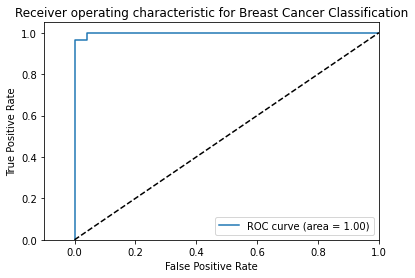

In [36]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr, tpr,label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.1, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for Breast Cancer Classification')
plt.legend(loc="lower right")
plt.show()